https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
pd.options.display.max_columns = 3
pd.options.display.max_colwidth = -1

In [3]:
import pickle
from collections import Counter

# Import Data

In [4]:
dataset = pd.read_json('Data\\Dataset.json', lines=True)

In [5]:
dataset.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697,mom starting to fear son's web series closest thing she will have to grandchild,1
3,https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb,j.k. rowling wishes snape happy birthday in the most magical way,0


In [6]:
print('There are {} samples out of which {} {:.2f} are sarcastic'.format(len(dataset), sum(dataset['is_sarcastic']), 100*sum(dataset['is_sarcastic'])/len(dataset)))

There are 26709 samples out of which 11724 43.90 are sarcastic


# Preprocessing

In [7]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

remove_punc = lambda x : re.sub(r"\W", ' ', x)

remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)

lower_case = lambda x : x.lower()

stop_words = set(nltk.corpus.stopwords.words('english'))
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)

ps = PorterStemmer()
ps_stem = lambda x: ' '.join(ps.stem(word) for word in x.split())

wnl = WordNetLemmatizer()
wnl_lemmatize = lambda x: ' '.join(wnl.lemmatize(word) for word in x.split())

def tag_pos(x):
    tag_list =  nltk.pos_tag(nltk.word_tokenize(x))
    pos = ""
    for t in tag_list:
        pos += t[0] +'(' + t[1] +')' + ' '
    return pos

def cleanText(x, rsw, stm, lem, tgps):
    x = remove_punc(x)
    x = remove_extra_spaces(x)
    x = lower_case(x)
    if rsw:
        x = remove_stopwords(x)
    if stm:
        x = ps_stem(x)
    if lem:
        x = wnl_lemmatize(x)
    if tgps:
        x = tag_pos(x)
    return x

#### Cleaning

In [8]:
X = pd.DataFrame()
X['headline'] = dataset['headline'].apply(lambda x : cleanText(x, True, False, False, False))
X.head()

,headline
0,former versace store clerk sues secret black code minority shoppers
1,roseanne revival catches thorny political mood better worse
2,mom starting fear son web series closest thing grandchild
3,boehner wants wife listen come alternative debt reduction ideas
4,j k rowling wishes snape happy birthday magical way


#### Vectorizing

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
cVect = CountVectorizer(ngram_range=(1,3))
cVect.fit(X['headline'])
pickle.dump(cVect, open('v1/cVect.pickle', 'wb'))

In [11]:
tVect = TfidfVectorizer(ngram_range=(1,3))
tVect.fit(X['headline'])
pickle.dump(tVect, open('v1/tVect.pickle', 'wb'))

In [12]:
X_Cvect = cVect.transform(X['headline'])
X_Tvect = tVect.transform(X['headline'])

In [13]:
y = dataset['is_sarcastic']

# EDA

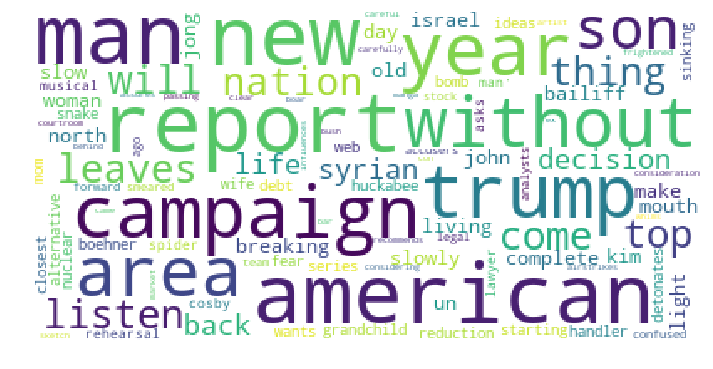

In [14]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

corpus = dataset[dataset['is_sarcastic'] == 1]['headline']
wordcloud = WordCloud(background_color='white', stopwords=STOPWORDS ,max_words=100, max_font_size=50, random_state=42).generate(str(corpus))
fig = plt.figure(figsize=(12,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Machine Learning

In [15]:
from sklearn.model_selection import cross_val_score

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
model = LogisticRegression()
scores = cross_val_score(model, X_Cvect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

Accuracy: 0.81 (+/- 0.01)


In [18]:
model = LogisticRegression()
scores = cross_val_score(model, X_Tvect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

Accuracy: 0.77 (+/- 0.01)


### Multinomial NB

In [19]:
from sklearn.naive_bayes import MultinomialNB

In [20]:
model = MultinomialNB()
scores = cross_val_score(model, X_Cvect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

Accuracy: 0.82 (+/- 0.01)


In [21]:
model = MultinomialNB()
scores = cross_val_score(model, X_Tvect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

Accuracy: 0.77 (+/- 0.01)


### Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier

D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
model = RandomForestClassifier()
scores = cross_val_score(model, X_Cvect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

Accuracy: 0.73 (+/- 0.00)


In [24]:
model = RandomForestClassifier()
scores = cross_val_score(model, X_Tvect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

Accuracy: 0.74 (+/- 0.01)


### SGDC Classifier

In [25]:
from sklearn.linear_model import SGDClassifier

In [26]:
model = SGDClassifier()
scores = cross_val_score(model, X_Cvect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Users\Ritvik\Anaconda3\lib\

Accuracy: 0.81 (+/- 0.01)


D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [27]:
model = SGDClassifier()
scores = cross_val_score(model, X_Tvect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' %(scores.mean(), scores.std()))

D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
D:\Users\Ritvik\Anaconda3\lib\

Accuracy: 0.75 (+/- 0.01)


## Model Pickling

In [34]:
model = LogisticRegression()
model.fit(X_Cvect, y)
pickle.dump(model, open('v1/LR-C.pickle', 'wb'))

In [35]:
model = LogisticRegression()
model.fit(X_Tvect, y)
pickle.dump(model, open('v1/LR-T.pickle', 'wb'))

In [36]:
model = MultinomialNB()
model.fit(X_Cvect, y)
pickle.dump(model, open('v1/MNB-C.pickle', 'wb'))

In [37]:
model = MultinomialNB()
model.fit(X_Tvect, y)
pickle.dump(model, open('v1/MNB-T.pickle', 'wb'))

In [38]:
model = RandomForestClassifier()
model.fit(X_Cvect, y)
pickle.dump(model, open('v1/RFC-C.pickle', 'wb'))

In [39]:
model = RandomForestClassifier()
model.fit(X_Tvect, y)
pickle.dump(model, open('v1/RFC-T.pickle', 'wb'))

In [40]:
model = SGDClassifier()
model.fit(X_Cvect, y)
pickle.dump(model, open('v1/SGDC-C.pickle', 'wb'))

D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [41]:
model = SGDClassifier()
model.fit(X_Tvect, y)
pickle.dump(model, open('v1/SGDC-T.pickle', 'wb'))

D:\Users\Ritvik\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


# Getting Predictions

In [42]:
TVectorizer = pickle.load(open('v1/tVect.pickle', 'rb'))
CVectorizer = pickle.load(open('v1/cVect.pickle', 'rb'))
LR_C = pickle.load(open('v1/LR-C.pickle', 'rb'))
LR_T = pickle.load(open('v1/LR-T.pickle', 'rb'))
MNB_C = pickle.load(open('v1/MNB-C.pickle', 'rb'))
MNB_T = pickle.load(open('v1/MNB-T.pickle', 'rb'))
RFC_C = pickle.load(open('v1/RFC-C.pickle', 'rb'))
RFC_T = pickle.load(open('v1/RFC-T.pickle', 'rb'))
SGDC_C = pickle.load(open('v1/SGDC-C.pickle', 'rb'))
SGDC_T = pickle.load(open('v1/SGDC-T.pickle', 'rb'))

In [43]:
def isSarcastic(text):
    cleaned_text = cleanText(text, True, False, False, False)
    cleaned_text = [cleaned_text]
    cVector = CVectorizer.transform(cleaned_text)
    tVector = TVectorizer.transform(cleaned_text)
    predictions = []
    predictions.append(LR_C.predict(cVector)[0])
    predictions.append(MNB_C.predict(cVector)[0])
    predictions.append(SGDC_C.predict(cVector)[0])
    predictions.append(RFC_C.predict(cVector)[0])
    predictions.append(LR_T.predict(tVector)[0])
    predictions.append(MNB_T.predict(tVector)[0])
    predictions.append(SGDC_T.predict(tVector)[0])
    predictions.append(RFC_T.predict(tVector)[0])
    print(predictions)
    prediction, confidence = Counter(predictions).most_common(1)[0]
    confidence /= 8
    print('Not Sarcastic, Confidence: {:.2f}'.format(confidence)) if prediction == 0 else print('Sarcastic, Confidence: {:.2f}'.format(confidence))
        

In [44]:
isSarcastic("you are tall")

[0, 1, 0, 0, 1, 1, 0, 0]
Not Sarcastic, Confidence: 0.62


In [45]:
isSarcastic("you are tall as a giant dwarf")

[0, 1, 1, 0, 1, 1, 1, 0]
Sarcastic, Confidence: 0.62


In [46]:
isSarcastic("you are very nice thank you so much")

[0, 1, 0, 0, 1, 0, 0, 0]
Not Sarcastic, Confidence: 0.75


In [47]:
isSarcastic("you are very nice little pumpkin")

[1, 1, 1, 0, 1, 1, 1, 0]
Sarcastic, Confidence: 0.75
